In [1]:
import sys
sys.path.append("..")

from models import Yolov4
from tensorflow import keras
from config import yolo_config    # 要記得改!!!!!!
from utils import DataGenerator, read_annotation_lines

import pickle
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import os
# 使用第一張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
# import random
# seed = 500
# tf.random.set_seed(500)
# np.random.seed(seed)
# random.seed(seed)

In [3]:
#1102是沒有10%背
#1104是有10%背景
train_lines = read_annotation_lines('../dataset/txt/20221104_anno_train_lines_0.txt')   
val_lines   = read_annotation_lines('../dataset/txt/20221104_anno_val_lines_0.txt')

In [7]:
FOLDER_PATH     = '../dataset/img/20230104_train_vali_img_nosmooth_haveBG'         # image位置
class_name_path = '../class_names/classes.txt'                              # class位置
data_gen_train  = DataGenerator(train_lines, class_name_path, FOLDER_PATH)  
data_gen_vali   = DataGenerator(val_lines, class_name_path, FOLDER_PATH)

model = Yolov4(weight_path=None, class_name_path=class_name_path)

nms iou: 0.6 score: 0.6


In [8]:
print('訓練集數量= ', len(train_lines),'驗證集數量= ',len(val_lines))

訓練集數量=  422 驗證集數量=  192


# 訓練自己的模型

In [9]:
# class LossHistory(keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.losses = []
        
#     def on_batch_end(self, batch, logs={}):
#         self.losses.append(logs.get('loss'))

# history = LossHistory()
''''''''''''''''''''''''''''''''''''''
day = '20230104'
checkpoint_filepath = '../model/202301/{}_nosmooth.weights'.format(day)
val_loss_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

## TODO:
val_mAP_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='auc',
    mode='max',
    save_best_only=True
    )


callbacks = [val_loss_checkpoint_callback, 
            #  val_mAP_checkpoint_callback
            ]
            
epochs    = 100
his = model.fit(train_data_gen=data_gen_train, 
                initial_epoch = 0,
                epochs       = epochs, 
                val_data_gen = data_gen_vali,
                callbacks    = callbacks,
          )

Epoch 1/100


2023-01-03 15:19:23.175610: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-01-03 15:19:24.245726: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


53/53 [==============================] - 37s 494ms/step - loss: 13093.1611 - val_loss: 24607.7441
Epoch 2/100
53/53 [==============================] - 24s 455ms/step - loss: 319.1387 - val_loss: 5208.7202
Epoch 3/100
53/53 [==============================] - 24s 449ms/step - loss: 232.7547 - val_loss: 1978.8346
Epoch 4/100
53/53 [==============================] - 24s 452ms/step - loss: 188.6609 - val_loss: 927.0858
Epoch 5/100
53/53 [==============================] - 24s 451ms/step - loss: 165.5403 - val_loss: 859.6635
Epoch 6/100
53/53 [==============================] - 24s 451ms/step - loss: 148.8112 - val_loss: 466.7723
Epoch 7/100
53/53 [==============================] - 24s 449ms/step - loss: 133.5535 - val_loss: 250.4920
Epoch 8/100
53/53 [==============================] - 24s 446ms/step - loss: 126.3062 - val_loss: 208.3264
Epoch 9/100
53/53 [==============================] - 22s 406ms/step - loss: 120.0243 - val_loss: 210.6705
Epoch 10/100
53/53 [==============================] 

# 畫圖

In [10]:
loss     = his.history['loss']
val_loss = his.history['val_loss']

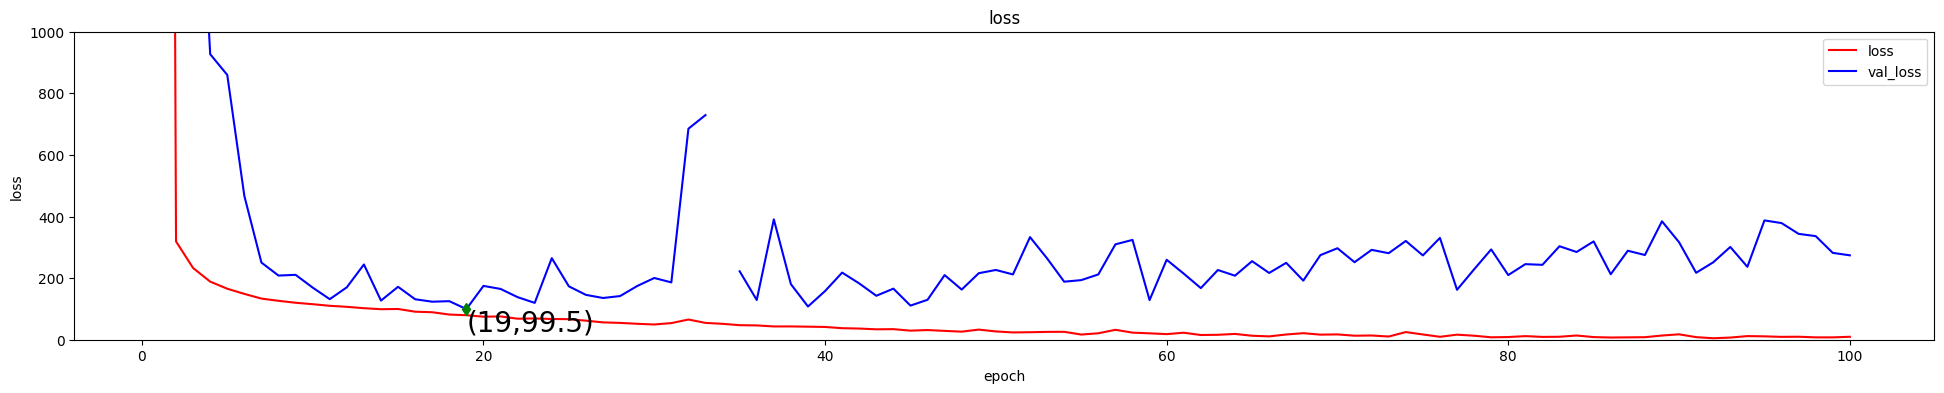

In [11]:
x = [i for i in range(1, epochs+1)]

min_valloss_x = val_loss.index(min(val_loss)) + 1
min_valloss_y = min(val_loss)

plt.figure(figsize=(24,4))
plt.plot(x, loss, 'r')     
plt.plot(x, val_loss, 'b')     # red dotted line (no marker)

plt.plot(min_valloss_x, min_valloss_y, 'd', color='g')
plt.text(min_valloss_x, min_valloss_y, "({},{})".format(min_valloss_x,round(min_valloss_y,1)), ha='left',va='top',fontsize=20)

plt.legend(['loss','val_loss'])
plt.ylim((0, 1000))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss')
plt.savefig('../model/202301/{}_loss.png'.format(day),
            bbox_inches='tight',
            pad_inches=1,
            transparent=False)
plt.show()

In [12]:
with open('../model/202301/{}_val_loss.list'.format(day),'wb') as f:
    pickle.dump(val_loss,f) 

In [13]:
with open('../model/202301/{}_loss.list'.format(day),'wb') as f:
    pickle.dump(loss,f) 

In [14]:
with open('../model/202301/{}_loss.his'.format(day),'wb') as f:
    pickle.dump(his,f) 

INFO:tensorflow:Assets written to: ram://717406e6-549d-4ce2-a5c3-43dd270b6e65/assets


INFO:tensorflow:Assets written to: ram://717406e6-549d-4ce2-a5c3-43dd270b6e65/assets
